## Modelling

The goal of the section is to develop a model with best model evaluation parameters. Numerous algorithms will be tested followed by hyperparameter tuning to obtain a best performing model.  

## Importing basic libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy

import warnings
warnings.filterwarnings(action='ignore')


# Train-Test Splitting
from sklearn.model_selection import train_test_split

# Data Scaling using MinMax Scalar
from sklearn.preprocessing import MinMaxScaler

#Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost 
from xgboost import XGBClassifier
import lightgbm 
from lightgbm import LGBMClassifier


# Model evaluation matrices
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score

#Class balance
from imblearn.over_sampling import SMOTE

#PCA
from sklearn.decomposition import PCA

#Gridsearch/Randomizedsearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


## 1) Baseline Model 

For the classification problem, baseline model can be considered as a model with area under ROC curve equal to 0.5. Here we consider a slightly higher predictive model, Logistic regression model as a baseline model considering the data from the main dataset: Application Train.


In [ ]:
# Load datasets: df contains data from Application_train dataset
df = pd.read_csv('Final_data/final_application_train_corr_0.98.csv')
df.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,FLAG_DOCUMENT_2_1,FLAG_DOCUMENT_3_1,FLAG_DOCUMENT_4_1,FLAG_DOCUMENT_5_1,FLAG_DOCUMENT_6_1,FLAG_DOCUMENT_7_1,FLAG_DOCUMENT_8_1,FLAG_DOCUMENT_9_1,FLAG_DOCUMENT_10_1,FLAG_DOCUMENT_11_1,FLAG_DOCUMENT_12_1,FLAG_DOCUMENT_13_1,FLAG_DOCUMENT_14_1,FLAG_DOCUMENT_15_1,FLAG_DOCUMENT_16_1,FLAG_DOCUMENT_17_1,FLAG_DOCUMENT_18_1,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_1
0,100002,1,202500.0,406597.5,24700.5,0.018801,9461,637,3648.0,2120,0.0,10,0.083037,0.262949,0.139376,0.02470,0.036900,0.972200,0.619200,0.014300,0.000000,0.069000,0.083300,0.125000,0.036900,0.020200,0.019000,0.000000,0.00000,0.025200,0.038300,0.972200,0.014400,0.000000,0.069000,0.037700,0.022000,0.019800,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,270000.0,1293502.5,35698.5,0.003541,16765,1188,1186.0,291,0.0,11,0.311267,0.622246,0.521008,0.09590,0.052900,0.985100,0.796000,0.060500,0.080000,0.034500,0.291700,0.333300,0.013000,0.077300,0.054900,0.003900,0.00980,0.092400,0.053800,0.985100,0.049700,0.080600,0.034500,0.012800,0.079000,0.055400,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100004,0,67500.0,135000.0,6750.0,0.010032,19046,225,4260.0,2531,26.0,9,0.511522,0.555912,0.729567,0.11746,0.088453,0.977731,0.752471,0.044619,0.078962,0.149741,0.226312,0.231916,0.066338,0.100787,0.107424,0.008811,0.02836,0.114249,0.087553,0.977061,0.042551,0.074508,0.145208,0.064962,0.105657,0.105999,0.008078,0.027024,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,0.008019,19005,3039,9833.0,2437,0.0,17,0.511522,0.650442,0.521008,0.11746,0.088453,0.977731,0.752471,0.044619,0.078962,0.149741,0.226312,0.231916,0.066338,0.100787,0.107424,0.008811,0.02836,0.114249,0.087553,0.977061,0.042551,0.074508,0.145208,0.064962,0.105657,0.105999,0.008078,0.027024,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,21865.5,0.028663,19932,3038,4311.0,3458,0.0,11,0.511522,0.322738,0.521008,0.11746,0.088453,0.977731,0.752471,0.044619,0.078962,0.149741,0.226312,0.231916,0.066338,0.100787,0.107424,0.008811,0.02836,0.114249,0.087553,0.977061,0.042551,0.074508,0.145208,0.064962,0.105657,0.105999,0.008078,0.027024,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### Test train split and scaling

In [ ]:
# Variable separation: Features and Target
X=df.drop(['TARGET','SK_ID_CURR'], axis=1).values
y=df['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

### Baseline Model: Logistic Regression

Test Data Metrics:
[[56038   463]
 [ 4603   340]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56501
           1       0.42      0.07      0.12      4943

    accuracy                           0.92     61444
   macro avg       0.67      0.53      0.54     61444
weighted avg       0.88      0.92      0.89     61444



Train Data Metrics:
[[224154   1758]
 [ 18411   1449]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96    225912
           1       0.45      0.07      0.13     19860

    accuracy                           0.92    245772
   macro avg       0.69      0.53      0.54    245772
weighted avg       0.89      0.92      0.89    245772



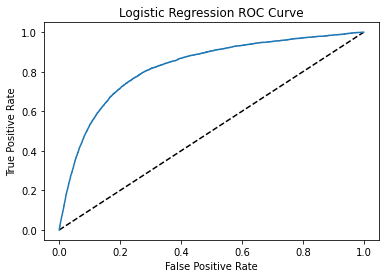



ROC_AUC Score:
roc_auc (test): 0.825
roc_auc (training): 0.823


In [ ]:
# Train the Logistic Regression model on the Training set
classifier_LR = LogisticRegression(random_state = 0)
classifier_LR.fit(X_train, y_train)

# Predic the Test set results
y_pred = classifier_LR.predict(X_test)

# Model evaluation matrices
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

#ROC_AUC Curve/Score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print('\n')
print('ROC_AUC Score:')
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))

**Baseline Model:** Roc_AUC(TEST)=0.825, the recall for 0 is exceptionally high and that for 1 is extremely low.

# 2) Search for Best Model

### Data Overview



In [ ]:
#Load dataset: df contains application_train and features extracted from additional datasets 
df = pd.read_csv('Final_data/final_df_corr_0.98.csv')
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307216 entries, 0 to 307215
Data columns (total 528 columns):
 #   Column                                                          Non-Null Count   Dtype  
---  ------                                                          --------------   -----  
 0   SK_ID_CURR                                                      307216 non-null  int64  
 1   TARGET                                                          307216 non-null  int64  
 2   AMT_INCOME_TOTAL                                                307216 non-null  float64
 3   AMT_CREDIT                                                      307216 non-null  float64
 4   AMT_ANNUITY                                                     307216 non-null  float64
 5   REGION_POPULATION_RELATIVE                                      307216 non-null  float64
 6   DAYS_BIRTH                                                      307216 non-null  int64  
 7   DAYS_EMPLOYED                        

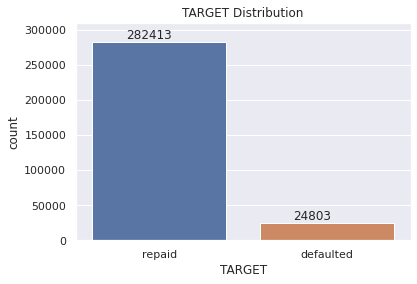

In [ ]:
#Targets
sns.set()
ax=sns.countplot(df['TARGET'])
plt.xticks([1,0],['defaulted', 'repaid'])
plt.ylim([0,310000])
plt.title('TARGET Distribution')

for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+5000))

In [ ]:
#check for null values
df.isnull().values.any()

False

### Test train split and scaling

In [ ]:
# Variable separation: Features and Target
X=df.drop(['TARGET','SK_ID_CURR'], axis=1).values
y=df['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
Models=['LR','Weighted_LR', 'L1/LR','Elastic_LR','DT','Weighted_DT','RF','Weighted_RF', 'AdaBoost','XgBoost','Weighted_XgBoost','LGBM', 'Weighted_LGBM']
print(Models)

['LR', 'Weighted_LR', 'L1/LR', 'Elastic_LR', 'DT', 'Weighted_DT', 'RF', 'Weighted_RF', 'AdaBoost', 'XgBoost', 'Weighted_XgBoost', 'LGBM', 'Weighted_LGBM']


In [ ]:
Pred_test=[]
Pred_train=[]
Pred_prob=[]
Pred_prob_train=[]

models=[LogisticRegression(random_state = 0),
    LogisticRegression(random_state = 0, class_weight={0:1,1:10}),
    LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1'),
    LogisticRegression(solver='saga', random_state = 0, class_weight={0:1,1:10}, penalty='elasticnet', l1_ratio=0.5),
    DecisionTreeClassifier(random_state = 0),
    DecisionTreeClassifier(class_weight={0:1,1:10},random_state = 0),
    RandomForestClassifier(random_state=0),
    RandomForestClassifier(random_state=0, class_weight={0:1,1:10}),
    AdaBoostClassifier(random_state = 0),
    XGBClassifier(random_stat=0),
    XGBClassifier(random_stat=0, scale_pos_weight=10),
    LGBMClassifier(random_state=0),
    LGBMClassifier(random_stat=0, scale_pos_weight=10)]

for clf in models:
    clf.fit(X_train, y_train)
    pred_test=clf.predict(X_test)
    pred_train=clf.predict(X_train)
    pred_prob = clf.predict_proba(X_test)[:,1]
    pred_prob_train = clf.predict_proba(X_train)[:,1]
    
    Pred_test.append(pred_test)
    Pred_train.append(pred_train)
    Pred_prob.append(pred_prob)
    Pred_prob_train.append(pred_prob_train)
    
    
    
    # Report the confusion matrix
    print('\033[1m'+'Model: '+str(type(clf).__name__)+'\033[0m')
    print('Confusion metrices:')
    print(metrics.confusion_matrix(y_test,pred_test))

    # Print a classification report
    print('classification Report:')
    print(metrics.classification_report(y_test,pred_test))
    
    print('ROC_AUC:')  
    print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, pred_prob_train)))
    print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, pred_prob)))
    
    print('\n')


Model: LogisticRegression
Confusion metrices:
[[55991   510]
 [ 4454   489]]
classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     56501
           1       0.49      0.10      0.16      4943

    accuracy                           0.92     61444
   macro avg       0.71      0.54      0.56     61444
weighted avg       0.89      0.92      0.89     61444

ROC_AUC:
roc_auc (training): 0.831
roc_auc (test): 0.833


Model: LogisticRegression
Confusion metrices:
[[45285 11216]
 [ 1267  3676]]
classification Report:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88     56501
           1       0.25      0.74      0.37      4943

    accuracy                           0.80     61444
   macro avg       0.61      0.77      0.62     61444
weighted avg       0.91      0.80      0.84     61444

ROC_AUC:
roc_auc (training): 0.835
roc_auc (test): 0.836


Model: LogisticRegression
Co

### Feature Importance

In [ ]:
classifier_LGBM = LGBMClassifier(random_stat=0, scale_pos_weight=10)
classifier_LGBM.fit(X_train, y_train)

feature_importance_LGBM = classifier_LGBM.feature_importance()
features= df.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).columns
feature_importances_LGBM=pd.DataFrame(list(zip(features,feature_importance_LGBM/max(feature_importance_LGBM)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LGBM.head(10)

,features,importance
10,EXT_SOURCE_1,100.000000
12,EXT_SOURCE_3,98.122867
11,EXT_SOURCE_2,45.051195
2,AMT_ANNUITY,11.945392
310,POS_CASH_CNT_INSTALMENT_FUTURE_mean,11.604096
1,AMT_CREDIT,9.385666
4,DAYS_BIRTH,9.044369
68,bureau_DAYS_CREDIT_min,8.703072
5,DAYS_EMPLOYED,8.532423
130,bureau_DAYS_CREDIT_UPDATE_mean,8.191126


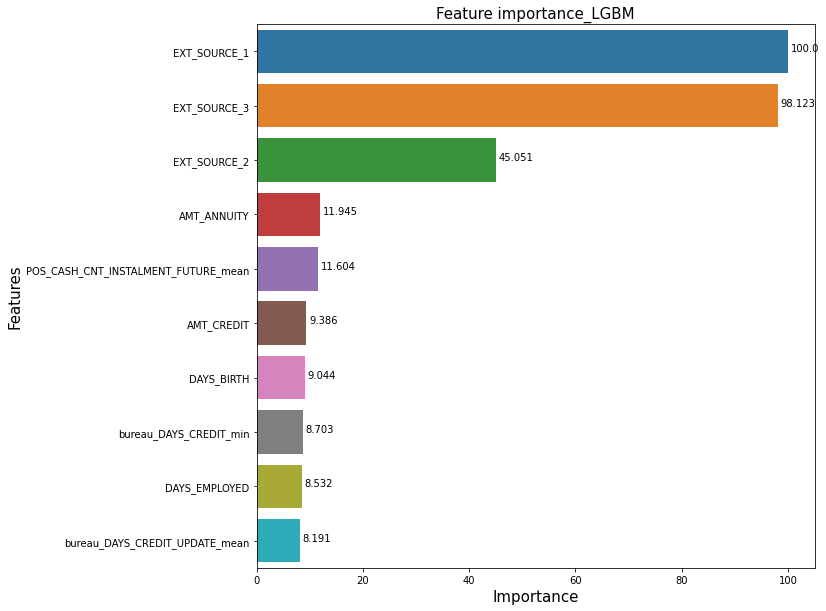

In [ ]:
plt.figure(figsize=(10,10))
ax=sns.barplot(y="features", x="importance", data=feature_importances_LGBM.head(10), orient='h')
ax.set_xlabel('Importance', fontsize=15)
ax.set_ylabel('Features', fontsize=15)
for p in ax.patches:
        x = p.get_x() + p.get_width() + 0.5
        y = p.get_y() + p.get_height()/2
        ax.annotate(round(p.get_width(),3), (x, y))

_=ax.set_title('Feature importance_LGBM', fontsize=15)


# Suspicious EXT_SOURCES

Boosting tree based model gave an extremely high model evaluation matrices. The EXT_SOURCES highly dominated these model. These parameters are not clearly explained in the datasets. Hence, there is a possibility of data leakage, target might be wrongly incorporated into the EXT_SOURCES. Hence, I decided to build a model without these external sources.

# 3) Baseline Model without External sources

In [ ]:
df = pd.read_csv('Final_data/final_application_train_corr_0.98.csv')

# Variable separation: Features and Target
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3' ], axis=1).values
y=df['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
# Training the Logistic Regression model on the Training set
classifier_LR = LogisticRegression(random_state = 0)
classifier_LR.fit(X_train, y_train)

# Predict the Test set results
y_pred = classifier_LR.predict(X_test)

# Model evaluation matrices
from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

#ROC_AUC Score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print('\n')
print('ROC_AUC Score:')
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))

Test Data Metrics:
[[56501     0]
 [ 4943     0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56501
           1       0.00      0.00      0.00      4943

    accuracy                           0.92     61444
   macro avg       0.46      0.50      0.48     61444
weighted avg       0.85      0.92      0.88     61444



Train Data Metrics:
[[225911      1]
 [ 19860      0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    225912
           1       0.00      0.00      0.00     19860

    accuracy                           0.92    245772
   macro avg       0.46      0.50      0.48    245772
weighted avg       0.84      0.92      0.88    245772



ROC_AUC Score:
roc_auc (test): 0.685
roc_auc (training): 0.678


**Baseline Model:** Roc_AUC(TEST)=0.685, the model evaluation matrices for 1 are zero.

# 4) Search for better Model

In [ ]:
df = pd.read_csv('Final_data/final_df_corr_0.98.csv')
df.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,...,FLAG_DOCUMENT_5_1,FLAG_DOCUMENT_6_1,FLAG_DOCUMENT_7_1,FLAG_DOCUMENT_8_1,FLAG_DOCUMENT_9_1,FLAG_DOCUMENT_10_1,FLAG_DOCUMENT_11_1,FLAG_DOCUMENT_12_1,FLAG_DOCUMENT_13_1,FLAG_DOCUMENT_14_1,FLAG_DOCUMENT_15_1,FLAG_DOCUMENT_16_1,FLAG_DOCUMENT_17_1,FLAG_DOCUMENT_18_1,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_1,most_frequent_bureau_CREDIT_ACTIVE_Closed,most_frequent_bureau_CREDIT_ACTIVE_Sold,most_frequent_bureau_CREDIT_CURRENCY_currency 2,most_frequent_bureau_CREDIT_CURRENCY_currency 3,most_frequent_bureau_CREDIT_TYPE_Car loan,most_frequent_bureau_CREDIT_TYPE_Consumer credit,most_frequent_bureau_CREDIT_TYPE_Credit card,most_frequent_bureau_CREDIT_TYPE_Loan for business development,most_frequent_bureau_CREDIT_TYPE_Microloan,most_frequent_bureau_CREDIT_TYPE_Mortgage,most_frequent_bureau_CREDIT_TYPE_Other,most_frequent_cc_balance_NAME_CONTRACT_STATUS_Completed,most_frequent_cc_balance_NAME_CONTRACT_STATUS_Demand,most_frequent_cc_balance_NAME_CONTRACT_STATUS_Signed,most_frequent_POS_NAME_CONTRACT_STATUS_Amortized debt,most_frequent_POS_NAME_CONTRACT_STATUS_Approved,most_frequent_POS_NAME_CONTRACT_STATUS_Completed,most_frequent_POS_NAME_CONTRACT_STATUS_Demand,most_frequent_POS_NAME_CONTRACT_STATUS_Returned to the store,most_frequent_POS_NAME_CONTRACT_STATUS_Signed,most_frequent_previous_app_NAME_CONTRACT_STATUS_Not Approved,most_frequent_previous_app_NAME_CLIENT_TYPE_Other,most_frequent_previous_app_NAME_CLIENT_TYPE_Repeater
0,100002,1,202500.0,406597.5,24700.5,0.018801,9461,637,3648.0,2120,0.0,10,0.083037,0.262949,0.139376,0.02470,0.036900,0.972200,0.619200,0.014300,0.000000,0.069000,0.083300,0.125000,0.036900,0.020200,0.019000,0.000000,0.00000,0.025200,0.038300,0.972200,0.014400,0.000000,0.069000,0.037700,0.022000,0.019800,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,270000.0,1293502.5,35698.5,0.003541,16765,1188,1186.0,291,0.0,11,0.311267,0.622246,0.521008,0.09590,0.052900,0.985100,0.796000,0.060500,0.080000,0.034500,0.291700,0.333300,0.013000,0.077300,0.054900,0.003900,0.00980,0.092400,0.053800,0.985100,0.049700,0.080600,0.034500,0.012800,0.079000,0.055400,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,100004,0,67500.0,135000.0,6750.0,0.010032,19046,225,4260.0,2531,26.0,9,0.511522,0.555912,0.729567,0.11746,0.088453,0.977731,0.752471,0.044619,0.078962,0.149741,0.226312,0.231916,0.066338,0.100787,0.107424,0.008811,0.02836,0.114249,0.087553,0.977061,0.042551,0.074508,0.145208,0.064962,0.105657,0.105999,0.008078,0.027024,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,0.008019,19005,3039,9833.0,2437,0.0,17,0.511522,0.650442,0.521008,0.11746,0.088453,0.977731,0.752471,0.044619,0.078962,0.149741,0.226312,0.231916,0.066338,0.100787,0.107424,0.008811,0.02836,0.114249,0.087553,0.977061,0.042551,0.074508,0.145208,0.064962,0.105657,0.105999,0.008078,0.027024,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,100007,0,121500.0,513000.0,21865.5,0.028663,19932,3038,4311.0,3458,0.0,11,0.511522,0.322738,0.521008,0.11746,0.088453,0.977731,0.752471,0.044619,0.078962,0.149741,0.226312,0.231916,0.066338,0.100787,0.107424,0.008811,0.02836,0.114249,0.087553,0.97

In [ ]:
# Variable separation: Features and Target
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3' ], axis=1).values
y=df['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
X_train.shape

(245772, 523)

In [ ]:
Models=['LR','Weighted_LR', 'L1/LR','Elastic_LR','DT','Weighted_DT','RF','Weighted_RF', 'AdaBoost','XgBoost','Weighted_XgBoost','LGBM', 'Weighted_LGBM']
len(Models)

13

In [ ]:
Pred_test=[]
Pred_train=[]
Pred_prob=[]
Pred_prob_train=[]

models=[LogisticRegression(random_state = 0),
    LogisticRegression(random_state = 0, class_weight={0:1,1:10}),
    LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1'),
    LogisticRegression(solver='saga', random_state = 0, class_weight={0:1,1:10}, penalty='elasticnet', l1_ratio=0.5),
    DecisionTreeClassifier(random_state = 0),
    DecisionTreeClassifier(class_weight={0:1,1:10},random_state = 0),
    RandomForestClassifier(random_state=0),
    RandomForestClassifier(random_state=0, class_weight={0:1,1:10}),
    AdaBoostClassifier(random_state = 0),
    XGBClassifier(random_stat=0),
    XGBClassifier(random_stat=0, scale_pos_weight=10),
    LGBMClassifier(random_state=0),
    LGBMClassifier(random_stat=0, scale_pos_weight=10)]

for clf in models:
    clf.fit(X_train, y_train)
    pred_test=clf.predict(X_test)
    pred_train=clf.predict(X_train)
    pred_prob = clf.predict_proba(X_test)[:,1]
    pred_prob_train = clf.predict_proba(X_train)[:,1]
    
    Pred_test.append(pred_test)
    Pred_train.append(pred_train)
    Pred_prob.append(pred_prob)
    Pred_prob_train.append(pred_prob_train)
    
    
    
    # Report the confusion matrix
    print('\033[1m'+'Model: '+str(type(clf).__name__)+'\033[0m')
    print('Confusion metrices:')
    print(metrics.confusion_matrix(y_test,pred_test))

    # Print a classification report
    print('classification Report:')
    print(metrics.classification_report(y_test,pred_test))
    
    print('ROC_AUC:')  
    print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, pred_prob_train)))
    print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, pred_prob)))
    print('\n')


Model: LogisticRegression
Confusion metrices:
[[56464    37]
 [ 4898    45]]
classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56501
           1       0.55      0.01      0.02      4943

    accuracy                           0.92     61444
   macro avg       0.73      0.50      0.49     61444
weighted avg       0.89      0.92      0.88     61444

ROC_AUC:
roc_auc (training): 0.730
roc_auc (test): 0.738


Model: LogisticRegression
Confusion metrices:
[[40625 15876]
 [ 1835  3108]]
classification Report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56501
           1       0.16      0.63      0.26      4943

    accuracy                           0.71     61444
   macro avg       0.56      0.67      0.54     61444
weighted avg       0.89      0.71      0.78     61444

ROC_AUC:
roc_auc (training): 0.733
roc_auc (test): 0.739


Model: LogisticRegression
Co

**As expected, all these models show that the weighted models perfored better than the regular one. In addition, L1 regularized LR, XgBoost and LGBM are better than the other.** 

### Feature Importances

#### L1 Regularized LR

In [ ]:
classifier_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')
classifier_LR.fit(X_train, y_train)

feature_importances_LR=abs(classifier_LR.coef_)[0]
features= df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).columns
feature_importances_LR=pd.DataFrame(list(zip(features,feature_importances_LR/max(feature_importances_LR)*100)), columns=['features','importance']).sort_values('importance', ascending=False)
feature_importances_LR.head(10)

,features,importance
92,bureau_AMT_CREDIT_MAX_OVERDUE_var,100.000000
291,installments_payments_AMT_PAYMENT_min,94.657455
112,bureau_AMT_CREDIT_SUM_DEBT_var,52.795176
282,installments_payments_AMT_INSTALMENT_mean,51.658411
289,installments_payments_AMT_PAYMENT_mean,35.788552
91,bureau_AMT_CREDIT_MAX_OVERDUE_std,35.475669
272,installments_payments_NUM_INSTALMENT_NUMBER_sum,30.162013
290,installments_payments_AMT_PAYMENT_median,27.350495
274,installments_payments_NUM_INSTALMENT_NUMBER_var,27.081732
285,installments_payments_AMT_INSTALMENT_min,26.685145


### Weighted XgBoost

In [ ]:
classifier_xgb = XGBClassifier(random_stat=0, scale_pos_weight=10)
classifier_xgb.fit(X_train, y_train)

feature_importance_xgb = classifier_xgb.feature_importances_
features= df.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).columns
feature_importances_xgb=pd.DataFrame(list(zip(features,feature_importance_xgb/max(feature_importance_xgb)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_xgb.head(10)

,features,importance
356,NAME_EDUCATION_TYPE_Higher education,100.000000
520,most_frequent_previous_app_NAME_CONTRACT_STATU...,81.267853
398,REGION_RATING_CLIENT_W_CITY_3,77.847984
355,NAME_INCOME_TYPE_Working,74.403114
500,most_frequent_bureau_CREDIT_ACTIVE_Closed,63.374031
63,bureau_DAYS_CREDIT_median,55.605358
337,CODE_GENDER_M,53.995659
338,FLAG_OWN_CAR_Y,41.692932
319,POS_CASH_SK_DPD_DEF_mean,35.052559
227,credit_card_balance_CNT_DRAWINGS_CURRENT_std,34.916805


### Weighted LGBM

In [ ]:
classifier_LGBM = LGBMClassifier(random_stat=0, scale_pos_weight=10)
classifier_LGBM.fit(X_train, y_train)

feature_importance_LGBM = classifier_LGBM.feature_importance()
features= df.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).columns
feature_importances_LGBM=pd.DataFrame(list(zip(features,feature_importance_LGBM/max(feature_importance_LGBM)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LGBM.head(10)

,features,importance
1,AMT_CREDIT,100.000000
291,installments_payments_AMT_PAYMENT_min,96.268657
39,DAYS_LAST_PHONE_CHANGE,83.582090
5,DAYS_EMPLOYED,80.597015
4,DAYS_BIRTH,73.880597
307,POS_CASH_CNT_INSTALMENT_FUTURE_mean,65.671642
319,POS_CASH_SK_DPD_DEF_mean,60.447761
47,count_bureau_CREDIT_ACTIVE_type_Active,58.208955
337,CODE_GENDER_M,51.492537
106,bureau_AMT_CREDIT_SUM_DEBT_mean,47.014925


# 5) Models by resampling data to make a balanced dataset: Data resampled by SMOTE without including EXT_SOURCES


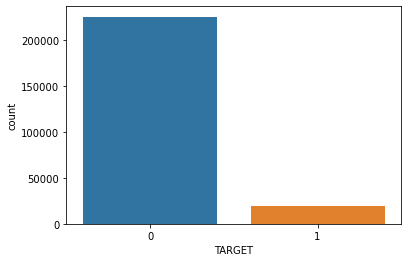

In [ ]:
df = pd.read_csv('Final_data/final_df_corr_0.98.csv')

X=df.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1)
y=df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
sns.countplot(pd.Series(y_train))

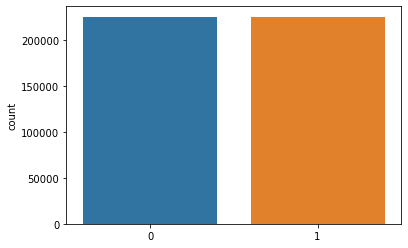

In [ ]:
sm = SMOTE(random_state = 101)

X_train_new, y_train_new = sm.fit_sample(X_train, y_train.ravel())

sns.countplot(pd.Series(y_train_new))

**Resampled data is well balanced.**

In [ ]:
scaler=MinMaxScaler()

X_train=scaler.fit_transform(X_train_new)
X_test=scaler.transform(X_test)
y_train=y_train_new

In [ ]:
Pred_test=[]
Pred_train=[]
Pred_prob=[]
Pred_prob_train=[]

models=[LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1'),
    XGBClassifier(random_stat=0, scale_pos_weight=10),
    LGBMClassifier(random_stat=0, scale_pos_weight=10)]

for clf in models:
    clf.fit(X_train, y_train)
    pred_test=clf.predict(X_test)
    pred_train=clf.predict(X_train)
    pred_prob = clf.predict_proba(X_test)[:,1]
    pred_prob_train = clf.predict_proba(X_train)[:,1]
    
    Pred_test.append(pred_test)
    Pred_train.append(pred_train)
    Pred_prob.append(pred_prob)
    Pred_prob_train.append(pred_prob_train)
    
    
    
    # Report the confusion matrix
    print('\033[1m'+'Model: '+str(type(clf).__name__)+'\033[0m')
    print('Confusion metrices:')
    print(metrics.confusion_matrix(y_test,pred_test))

    # Print a classification report
    print('classification Report:')
    print(metrics.classification_report(y_test,pred_test))
    
    print('ROC_AUC:')  
    print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, pred_prob_train)))
    print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, pred_prob)))
    
    print('\n')


Model: LogisticRegression
Confusion metrices:
[[38346 18155]
 [ 1703  3240]]
classification Report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56501
           1       0.15      0.66      0.25      4943

    accuracy                           0.68     61444
   macro avg       0.55      0.67      0.52     61444
weighted avg       0.89      0.68      0.75     61444

ROC_AUC:
roc_auc (training): 0.975
roc_auc (test): 0.720


[19:10:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { random_stat } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Model: XGBClassifier
Confusion metrices:
[[42957 13544]
 [ 2132  2811]]
classification Report:
              precision    rec

# 6) Dimensionality reduction: PCA

In [ ]:
df = pd.read_csv('Final_data/final_df_corr_0.98.csv')
df.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,most_frequent_cc_balance_NAME_CONTRACT_STATUS_Signed,most_frequent_POS_NAME_CONTRACT_STATUS_Amortized debt,most_frequent_POS_NAME_CONTRACT_STATUS_Approved,most_frequent_POS_NAME_CONTRACT_STATUS_Completed,most_frequent_POS_NAME_CONTRACT_STATUS_Demand,most_frequent_POS_NAME_CONTRACT_STATUS_Returned to the store,most_frequent_POS_NAME_CONTRACT_STATUS_Signed,most_frequent_previous_app_NAME_CONTRACT_STATUS_Not Approved,most_frequent_previous_app_NAME_CLIENT_TYPE_Other,most_frequent_previous_app_NAME_CLIENT_TYPE_Repeater
0,100002,1,202500.0,406597.5,24700.5,0.018801,9461,637,3648.0,2120,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,270000.0,1293502.5,35698.5,0.003541,16765,1188,1186.0,291,...,0,0,0,0,0,0,0,0,1,0
2,100004,0,67500.0,135000.0,6750.0,0.010032,19046,225,4260.0,2531,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,0.008019,19005,3039,9833.0,2437,...,0,0,0,0,0,0,0,0,0,1
4,100007,0,121500.0,513000.0,21865.5,0.028663,19932,3038,4311.0,3458,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).values
y=df['TARGET'].values

In [ ]:
scaler=MinMaxScaler()
X=scaler.fit_transform(X)

In [ ]:
pca = PCA(n_components=10)
principalComponents_df = pca.fit_transform(X)
print('Explained variation per principal components: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal components: [0.06729706 0.06174801 0.05117556 0.04686685 0.04055935 0.03451843
 0.0302898  0.02696171 0.02650794 0.02488631]


## 6.1) Visualization using two principal components 

In [ ]:
pca = PCA(n_components=2)
principalComponents_df = pca.fit_transform(X)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.06729706 0.061748  ]


In [ ]:
principal_df = pd.DataFrame(data = principalComponents_df, columns = ['principal component 1', 'principal component 2'])
principal_df.tail()

,principal component 1,principal component 2
307211,-0.822873,2.030606
307212,0.466988,1.136022
307213,0.419278,0.847454
307214,0.003509,0.371752
307215,0.515967,0.415458


<Figure size 432x288 with 0 Axes>

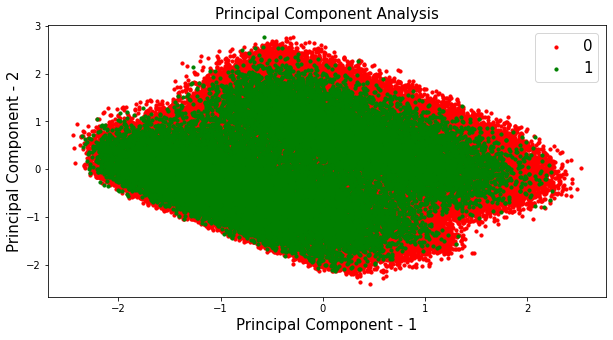

In [ ]:
plt.figure()
_=plt.figure(figsize=(10,5))
_=plt.xticks(fontsize=10)
_=plt.yticks(fontsize=10)
_=plt.xlabel('Principal Component - 1',fontsize=15)
_=plt.ylabel('Principal Component - 2',fontsize=15)
_=plt.title("Principal Component Analysis",fontsize=15)


targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = df['TARGET'] == target
    plt.scatter(principal_df.loc[indicesToKeep, 'principal component 1'], principal_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 10)

_=plt.legend(targets,prop={'size': 15})

**This shows that two class are not quite linearly separable when projected into two dimension, Tree based model might work best in this scenerio.**

## 6.2) LGBM Models using various PCs




### 6.2.1) LGBM using PCs=2

In [ ]:
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).values
y=df['TARGET'].values

scaler=MinMaxScaler()
X=scaler.fit_transform(X)


pca = PCA(n_components=2)
principalComponents_df = pca.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_test=scaler.transform(X_test)

pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test= pca.transform(X_test)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.0672814  0.06173943]


In [ ]:
#train the model 
classifier_LGBM=LGBMClassifier(n_estimators=100,scale_pos_weight= 10)
classifier_LGBM.fit(X_train,y_train)

#prediction
y_pred=classifier_LGBM.predict(X_test)
y_pred_train=classifier_LGBM.predict(X_train)

y_pred_prob=classifier_LGBM.predict_proba(X_test)[:,1]
y_pred_prob_train=classifier_LGBM.predict_proba(X_train)[:,1]

print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print('\n')
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[20475 36026]
 [ 1195  3748]]
              precision    recall  f1-score   support

           0       0.94      0.36      0.52     56501
           1       0.09      0.76      0.17      4943

    accuracy                           0.39     61444
   macro avg       0.52      0.56      0.35     61444
weighted avg       0.88      0.39      0.50     61444



Train Data Metrics:
[[167700  58212]
 [ 11406   8454]]
              precision    recall  f1-score   support

           0       0.94      0.74      0.83    225912
           1       0.13      0.43      0.20     19860

    accuracy                           0.72    245772
   macro avg       0.53      0.58      0.51    245772
weighted avg       0.87      0.72      0.78    245772



roc_auc (training): 0.632
roc_auc (test): 0.602


### 6.2.2) LGBM using PCs with explained varience >0.6

In [ ]:
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).values
y=df['TARGET'].values


scaler=MinMaxScaler()
X=scaler.fit_transform(X)

pca = PCA(n_components=2)
principalComponents_df = pca.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_test=scaler.transform(X_test)

pca = PCA(0.6)
X_train = pca.fit_transform(X_train)
X_test= pca.transform(X_test)
print(pca.n_components_)

print('sum of explained variation is: {}'.format(np.sum(pca.explained_variance_ratio_)))

21
sum of explained variation is: 0.60365794485796


In [ ]:
#train the model 
classifier_LGBM=LGBMClassifier(n_estimators=100,scale_pos_weight= 10)
classifier_LGBM.fit(X_train,y_train)

#prediction
y_pred=classifier_LGBM.predict(X_test)
y_pred_train=classifier_LGBM.predict(X_train)

y_pred_prob=classifier_LGBM.predict_proba(X_test)[:,1]
y_pred_prob_train=classifier_LGBM.predict_proba(X_train)[:,1]

print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print('\n')
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[24857 31644]
 [ 1244  3699]]
              precision    recall  f1-score   support

           0       0.95      0.44      0.60     56501
           1       0.10      0.75      0.18      4943

    accuracy                           0.46     61444
   macro avg       0.53      0.59      0.39     61444
weighted avg       0.88      0.46      0.57     61444



Train Data Metrics:
[[173327  52585]
 [ 10314   9546]]
              precision    recall  f1-score   support

           0       0.94      0.77      0.85    225912
           1       0.15      0.48      0.23     19860

    accuracy                           0.74    245772
   macro avg       0.55      0.62      0.54    245772
weighted avg       0.88      0.74      0.80    245772



roc_auc (training): 0.689
roc_auc (test): 0.640


### 6.2.3) Model using PCs with explained varience >0.8

In [ ]:
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).values
y=df['TARGET'].values


scaler=MinMaxScaler()
X=scaler.fit_transform(X)


pca = PCA(n_components=2)
principalComponents_df = pca.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_test=scaler.transform(X_test)

pca = PCA(0.8)
X_train = pca.fit_transform(X_train)
X_test= pca.transform(X_test)
print(pca.n_components_)

print('sum of explained variation is: {}'.format(np.sum(pca.explained_variance_ratio_)))

43
sum of explained variation is: 0.8020251922417508


In [ ]:
#train the model 
classifier_LGBM=LGBMClassifier(n_estimators=100,scale_pos_weight= 10)
classifier_LGBM.fit(X_train,y_train)

#prediction
y_pred=classifier_LGBM.predict(X_test)
y_pred_train=classifier_LGBM.predict(X_train)

y_pred_prob=classifier_LGBM.predict_proba(X_test)[:,1]
y_pred_prob_train=classifier_LGBM.predict_proba(X_train)[:,1]


print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print('\n')
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[42176 14325]
 [ 2706  2237]]
              precision    recall  f1-score   support

           0       0.94      0.75      0.83     56501
           1       0.14      0.45      0.21      4943

    accuracy                           0.72     61444
   macro avg       0.54      0.60      0.52     61444
weighted avg       0.87      0.72      0.78     61444



Train Data Metrics:
[[173438  52474]
 [  9506  10354]]
              precision    recall  f1-score   support

           0       0.95      0.77      0.85    225912
           1       0.16      0.52      0.25     19860

    accuracy                           0.75    245772
   macro avg       0.56      0.64      0.55    245772
weighted avg       0.88      0.75      0.80    245772



roc_auc (training): 0.715
roc_auc (test): 0.651


# 7) Best Models, Feature selection and Hyperparameter Tuning

**Analysis of model performance matrices shows LGBM and L1 regularized LR models are the best models.**

#### 7.1) LGBM

In [ ]:
df = pd.read_csv('Final_data/final_df_corr_0.98.csv')

X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)
y=df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
#train the model 
classifier_LGBM=LGBMClassifier(n_estimators=100,scale_pos_weight= 10)
classifier_LGBM.fit(X_train,y_train)

#prediction
y_pred=classifier_LGBM.predict(X_test)
y_pred_train=classifier_LGBM.predict(X_train)

y_pred_prob=classifier_LGBM.predict_proba(X_test)[:,1]
y_pred_prob_train=classifier_LGBM.predict_proba(X_train)[:,1]

print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print('\n')
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[44207 12176]
 [ 2379  2682]]
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     56383
           1       0.18      0.53      0.27      5061

    accuracy                           0.76     61444
   macro avg       0.56      0.66      0.56     61444
weighted avg       0.89      0.76      0.81     61444



Train Data Metrics:
[[178102  47928]
 [  8064  11678]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.86    226030
           1       0.20      0.59      0.29     19742

    accuracy                           0.77    245772
   macro avg       0.58      0.69      0.58    245772
weighted avg       0.90      0.77      0.82    245772



roc_auc (training): 0.768
roc_auc (test): 0.728


In [ ]:
feature_importance_LGBM = classifier_LGBM.feature_importance()
features= df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1).columns
feature_importances_LGBM=pd.DataFrame(list(zip(features,feature_importance_LGBM/max(feature_importance_LGBM)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LGBM.head(10)

,features,importance
1,AMT_CREDIT,100.000000
291,installments_payments_AMT_PAYMENT_min,87.323944
39,DAYS_LAST_PHONE_CHANGE,78.873239
5,DAYS_EMPLOYED,73.239437
319,POS_CASH_SK_DPD_DEF_mean,67.605634
4,DAYS_BIRTH,58.450704
106,bureau_AMT_CREDIT_SUM_DEBT_mean,54.929577
337,CODE_GENDER_M,50.704225
307,POS_CASH_CNT_INSTALMENT_FUTURE_mean,50.704225
47,count_bureau_CREDIT_ACTIVE_type_Active,49.295775


In [ ]:
to_drop_1=feature_importances_LGBM[feature_importances_LGBM['importance']==0]['features'].values.tolist()
print('No. of features to drop:{}'.format(len(to_drop_1)))

No. of features to drop:326


In [ ]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307216 entries, 0 to 307215
Data columns (total 528 columns):
 #   Column                                                          Non-Null Count   Dtype  
---  ------                                                          --------------   -----  
 0   SK_ID_CURR                                                      307216 non-null  int64  
 1   TARGET                                                          307216 non-null  int64  
 2   AMT_INCOME_TOTAL                                                307216 non-null  float64
 3   AMT_CREDIT                                                      307216 non-null  float64
 4   AMT_ANNUITY                                                     307216 non-null  float64
 5   REGION_POPULATION_RELATIVE                                      307216 non-null  float64
 6   DAYS_BIRTH                                                      307216 non-null  int64  
 7   DAYS_EMPLOYED                        

In [ ]:
not_to_drop_1=feature_importances_LGBM[feature_importances_LGBM['importance']>0]['features'].values.tolist()
print('No. of features not to drop:{}'.format(len(not_to_drop_1)))

No. of features not to drop:197


In [ ]:
df1=df.drop(to_drop_1, axis=1)
df1=df1.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)
df1.to_csv('Final_data/df including more than 0% feature importances_LGBM_without Ext source.csv',index=False)

##### Rechecking model after feature selection

In [ ]:
#df1 = pd.read_csv('submission/df including more than 0% feature importances_LGBM_without Ext source.csv')
X=df1.drop(['TARGET','SK_ID_CURR'], axis=1)
y=df1['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#train the model 
classifier_LGBM=LGBMClassifier(n_estimators=100,scale_pos_weight= 10)
classifier_LGBM.fit(X_train,y_train)

#prediction
y_pred=classifier_LGBM.predict(X_test)
y_pred_train=classifier_LGBM.predict(X_train)

y_pred_prob=classifier_LGBM.predict_proba(X_test)[:,1]
y_pred_prob_train=classifier_LGBM.predict_proba(X_train)[:,1]

print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print('\n')
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[44310 12111]
 [ 2283  2740]]
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     56421
           1       0.18      0.55      0.28      5023

    accuracy                           0.77     61444
   macro avg       0.57      0.67      0.57     61444
weighted avg       0.89      0.77      0.81     61444



Train Data Metrics:
[[177843  48149]
 [  8195  11585]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.86    225992
           1       0.19      0.59      0.29     19780

    accuracy                           0.77    245772
   macro avg       0.57      0.69      0.58    245772
weighted avg       0.89      0.77      0.82    245772



roc_auc (training): 0.766
roc_auc (test): 0.738


**The roc_auc remains almost similar after selected features.**

##### Grid search/Randomised Search

**Starting Model**

In [ ]:
df = pd.read_csv('Final_data/df including more than 0% feature importances_LGBM_without Ext source.csv')
df=df.sample(frac=0.5,random_state=0)


X=df.drop(['TARGET','SK_ID_CURR'], axis=1)
y=df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


#train the model 
classifier_LGBM=LGBMClassifier(n_estimators=100,scale_pos_weight= 10)
classifier_LGBM.fit(X_train,y_train)

#prediction
y_pred=classifier_LGBM.predict(X_test)
y_pred_train=classifier_LGBM.predict(X_train)

y_pred_prob=classifier_LGBM.predict_proba(X_test)[:,1]
y_pred_prob_train=classifier_LGBM.predict_proba(X_train)[:,1]


print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print('\n')
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[22174  6097]
 [ 1100  1351]]
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     28271
           1       0.18      0.55      0.27      2451

    accuracy                           0.77     30722
   macro avg       0.57      0.67      0.57     30722
weighted avg       0.89      0.77      0.81     30722



Train Data Metrics:
[[88987 23905]
 [ 3771  6223]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.87    112892
           1       0.21      0.62      0.31      9994

    accuracy                           0.77    122886
   macro avg       0.58      0.71      0.59    122886
weighted avg       0.90      0.77      0.82    122886



roc_auc (training): 0.787
roc_auc (test): 0.738


In [ ]:
#GRidSearch CV
param_grid = {
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25,50,100],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [0, 1, 2.5, 5, 10,15,20],
    'reg_lambda': [0,1,2.5,5,10,15,20],
    'min_split_gain': [0.3, 0.4, 0.8,1, 1.5],
    'scale_pos_weight':[5,8,9,10,11,12,15,20,50,100],
    'subsample': [0.5, 0.8, 0.9],
    'subsample_freq': [10,20,30,40],
    'learning_rate':[0.01,0.03,0.05,0.1,0.3,0.5,1]}
    
gsearch = GridSearchCV(estimator = LGBMClassifier(random_state=0), param_grid = param_grid, scoring='roc_auc', cv=5)
gsearch.fit(X_train,y_train)
gsearch.best_params_, gsearch.best_score_

**GRidsearch CV is computationally intensive.**

In [ ]:
# Randomized CV
param_grid = {
    'n_estimators':list(np.arange(150,200,2)),
   'colsample_bytree': list(np.linspace(0,1,11)),
    'max_depth': list(np.arange(10,100,5)),
    'num_leaves': list(np.arange(25, 100, 25)),
    'reg_alpha': [0, 1, 2.5, 5, 10,15,20],
    'reg_lambda': [0,1,2.5,5,10,15,20],
    'min_split_gain': [0.3, 0.4, 0.8,1.5],
    'scale_pos_weight':[7,8,9,10,11,12,13,14,15],
    'subsample': list(np.arange(0.2,1,0.1)),
    'subsample_freq': list(np.arange(10,50,5))}


clf = LGBMClassifier(random_state=0, learning_rate=0.05)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_grid, 
    n_iter=500,
    scoring='roc_auc',
    cv=5,
    refit=True,
    random_state=0,
    verbose=True)



# Fit the object to our data
gs.fit(X_train, y_train)


print(gs.best_score_)
print(gs.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed: 352.7min finished


0.7415161040771403
{'subsample_freq': 10, 'subsample': 0.9000000000000001, 'scale_pos_weight': 7, 'reg_lambda': 15, 'reg_alpha': 10, 'num_leaves': 25, 'n_estimators': 194, 'min_split_gain': 0.3, 'max_depth': 75, 'colsample_bytree': 0.5}


####  7.2) Regularized LR

In [ ]:
df = pd.read_csv('Final_data/final_df_corr_0.98.csv')

X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)
y=df['TARGET']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')
classifier_LR.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier_LR.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[41199 15222]
 [ 1881  3142]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56421
           1       0.17      0.63      0.27      5023

    accuracy                           0.72     61444
   macro avg       0.56      0.68      0.55     61444
weighted avg       0.89      0.72      0.78     61444



Train Data Metrics:
[[164884  61108]
 [  7404  12376]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83    225992
           1       0.17      0.63      0.27     19780

    accuracy                           0.72    245772
   macro avg       0.56      0.68      0.55    245772
weighted avg       0.89      0.72      0.78    245772

roc_auc (training): 0.744
roc_auc (test): 0.741


In [ ]:
feature_importance_LR=abs(classifier_LR.coef_)[0]
features= df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1).columns
feature_importances_LR=pd.DataFrame(list(zip(features,feature_importance_LR/max(feature_importance_LR)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LR.head(10)

,features,importance
291,installments_payments_AMT_PAYMENT_min,100.000000
92,bureau_AMT_CREDIT_MAX_OVERDUE_var,97.370284
282,installments_payments_AMT_INSTALMENT_mean,78.228313
112,bureau_AMT_CREDIT_SUM_DEBT_var,69.882895
289,installments_payments_AMT_PAYMENT_mean,52.943491
91,bureau_AMT_CREDIT_MAX_OVERDUE_std,34.905053
209,credit_card_balance_AMT_PAYMENT_CURRENT_sum,33.229722
272,installments_payments_NUM_INSTALMENT_NUMBER_sum,31.987363
126,bureau_AMT_CREDIT_SUM_OVERDUE_var,28.061540
110,bureau_AMT_CREDIT_SUM_DEBT_sum,27.407903


In [ ]:
to_drop=feature_importances_LR[feature_importances_LR['importance']<.05]['features'].values.tolist()
print('No. of features to drop: {}'.format(len(to_drop)))

No. of features to drop: 103


In [ ]:
df2=df.drop(to_drop, axis=1)
df2=df2.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)
df2.to_csv('Final_data/df including 0.5% feature importances_LR_without Ext source.csv',index=False)

##### Rechecking model using selected features

In [ ]:
#df = pd.read_csv('Final_data/df including 0.5% feature importances_LR_without Ext source.csv')

X=df2.drop(['TARGET','SK_ID_CURR'], axis=1)
y=df2['TARGET']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')
classifier_LR.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier_LR.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[41034 15467]
 [ 1791  3152]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56501
           1       0.17      0.64      0.27      4943

    accuracy                           0.72     61444
   macro avg       0.56      0.68      0.55     61444
weighted avg       0.89      0.72      0.78     61444



Train Data Metrics:
[[164375  61537]
 [  7417  12443]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83    225912
           1       0.17      0.63      0.27     19860

    accuracy                           0.72    245772
   macro avg       0.56      0.68      0.55    245772
weighted avg       0.89      0.72      0.78    245772

roc_auc (training): 0.743
roc_auc (test): 0.747


In [ ]:
# Fraction of Data
df = pd.read_csv('Final_data/df including 0.5% feature importances_LR_without Ext source.csv')
dff=df.sample(frac=0.25, random_state=0)

X=dff.drop(['TARGET','SK_ID_CURR'], axis=1)
y=dff['TARGET']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')
classifier_LR.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier_LR.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[10231  3829]
 [  521   780]]
              precision    recall  f1-score   support

           0       0.95      0.73      0.82     14060
           1       0.17      0.60      0.26      1301

    accuracy                           0.72     15361
   macro avg       0.56      0.66      0.54     15361
weighted avg       0.89      0.72      0.78     15361



Train Data Metrics:
[[41500 14987]
 [ 1754  3202]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56487
           1       0.18      0.65      0.28      4956

    accuracy                           0.73     61443
   macro avg       0.57      0.69      0.55     61443
weighted avg       0.90      0.73      0.79     61443

roc_auc (training): 0.758
roc_auc (test): 0.724


**Model evaluation matrices follows a similar trend with selected feature and fraction of Data. Hence, these frac of data for Grid SearchCV.**

#####  RandomSearch CV

**Starting Model**

In [ ]:
#df = pd.read_csv('Final_data/df including 0.5% feature importances_LR_without Ext source.csv')

X=df2.drop(['TARGET','SK_ID_CURR'], axis=1)
y=df2['TARGET']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')
classifier_LR.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier_LR.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[41034 15467]
 [ 1791  3152]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56501
           1       0.17      0.64      0.27      4943

    accuracy                           0.72     61444
   macro avg       0.56      0.68      0.55     61444
weighted avg       0.89      0.72      0.78     61444



Train Data Metrics:
[[164375  61537]
 [  7417  12443]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83    225912
           1       0.17      0.63      0.27     19860

    accuracy                           0.72    245772
   macro avg       0.56      0.68      0.55    245772
weighted avg       0.89      0.72      0.78    245772

roc_auc (training): 0.743
roc_auc (test): 0.747


In [ ]:
#RandomSearch CV
w = [{0:1,1:5},{0:1,1:7.5}, {0:1,1:10}, {0:1,1:12.5},{0:1,1:15}, {0:1,1:6},{0:1,1:7},{0:1,1:8}, {0:1,1:9}, {0:1,1:11},{0:1,1:12}, {0:1,1:13}, {0:1,1:14},{0:1,1:15}]

param_grid = {
    "class_weight": w,
    "C": list(np.arange(0,3,0.25))
}


from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')

rs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_grid, 
    n_iter=500,
    scoring='roc_auc',
    cv=5,
    refit=True,
    random_state=0,
    verbose=True)



# Fit the object to our data
rs.fit(X_train, y_train)


print(rs.best_score_)
print(rs.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 37.0min finished


0.7023865766546925
{'class_weight': {0: 1, 1: 5}, 'C': 1.0}


# 8) Final Models

In [ ]:
df = pd.read_csv('Final_data/final_df_corr_0.98.csv')
df.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,most_frequent_cc_balance_NAME_CONTRACT_STATUS_Signed,most_frequent_POS_NAME_CONTRACT_STATUS_Amortized debt,most_frequent_POS_NAME_CONTRACT_STATUS_Approved,most_frequent_POS_NAME_CONTRACT_STATUS_Completed,most_frequent_POS_NAME_CONTRACT_STATUS_Demand,most_frequent_POS_NAME_CONTRACT_STATUS_Returned to the store,most_frequent_POS_NAME_CONTRACT_STATUS_Signed,most_frequent_previous_app_NAME_CONTRACT_STATUS_Not Approved,most_frequent_previous_app_NAME_CLIENT_TYPE_Other,most_frequent_previous_app_NAME_CLIENT_TYPE_Repeater
0,100002,1,202500.0,406597.5,24700.5,0.018801,9461,637,3648.0,2120,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,270000.0,1293502.5,35698.5,0.003541,16765,1188,1186.0,291,...,0,0,0,0,0,0,0,0,1,0
2,100004,0,67500.0,135000.0,6750.0,0.010032,19046,225,4260.0,2531,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,0.008019,19005,3039,9833.0,2437,...,0,0,0,0,0,0,0,0,0,1
4,100007,0,121500.0,513000.0,21865.5,0.028663,19932,3038,4311.0,3458,...,0,0,0,0,0,0,0,0,0,1


###### LR

In [ ]:
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)
y=df['TARGET']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:6}, penalty='l1', C=0.5)
classifier_LR.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier_LR.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('\n')
print('Train Data Metrics:')
y_pred = classifier_LR.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))


from sklearn.metrics import roc_auc_score
y_pred_prob = classifier_LR.predict_proba(X_test)[:,1]
y_pred_prob_train = classifier_LR.predict_proba(X_train)[:,1]
    
print('\n')
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))


Test Data Metrics:
[[49795  6626]
 [ 3084  1939]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     56421
           1       0.23      0.39      0.29      5023

    accuracy                           0.84     61444
   macro avg       0.58      0.63      0.60     61444
weighted avg       0.88      0.84      0.86     61444



Train Data Metrics:
[[199227  26765]
 [ 11929   7851]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91    225992
           1       0.23      0.40      0.29     19780

    accuracy                           0.84    245772
   macro avg       0.59      0.64      0.60    245772
weighted avg       0.89      0.84      0.86    245772



roc_auc (test): 0.740
roc_auc (training): 0.742


In [ ]:
feature_importance_LR=abs(classifier_LR.coef_)[0]
features= df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1).columns
feature_importances_LR=pd.DataFrame(list(zip(features,feature_importance_LR/max(feature_importance_LR)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LR.head(10)

,features,importance
291,installments_payments_AMT_PAYMENT_min,100.000000
272,installments_payments_NUM_INSTALMENT_NUMBER_sum,34.781679
289,installments_payments_AMT_PAYMENT_mean,31.309347
110,bureau_AMT_CREDIT_SUM_DEBT_sum,28.468867
282,installments_payments_AMT_INSTALMENT_mean,27.858136
274,installments_payments_NUM_INSTALMENT_NUMBER_var,27.153778
209,credit_card_balance_AMT_PAYMENT_CURRENT_sum,26.714690
112,bureau_AMT_CREDIT_SUM_DEBT_var,20.161101
322,count_POS_NAME_CONTRACT_STATUS_type_Active,19.169655
44,AMT_REQ_CREDIT_BUREAU_QRT,18.398242


##### LGBM

In [ ]:
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)
y=df['TARGET']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


#train the model 
classifier_LGBM=LGBMClassifier(n_estimators=194, learning_rate=0.05,
 boosting_type='gbdt',
 objective='binary',
 metric='binary_logloss',
 max_depth= 75,
 subsample_freq= 10,
 subsample= 0.9,
 scale_pos_weight= 8,
 reg_lambda= 15,
 reg_alpha= 10,
 num_leaves= 25,
 min_split_gain= 0.3,
 colsample_bytree= 0.5)

classifier_LGBM.fit(X_train,y_train)

#prediction
y_pred=classifier_LGBM.predict(X_test)
y_pred_train=classifier_LGBM.predict(X_train)

y_pred_prob=classifier_LGBM.predict_proba(X_test)[:,1]
y_pred_prob_train=classifier_LGBM.predict_proba(X_train)[:,1]


print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))

Test Data Metrics:
[[46449  9972]
 [ 2435  2588]]
              precision    recall  f1-score   support

           0       0.95      0.82      0.88     56421
           1       0.21      0.52      0.29      5023

    accuracy                           0.80     61444
   macro avg       0.58      0.67      0.59     61444
weighted avg       0.89      0.80      0.83     61444



Train Data Metrics:
[[186951  39041]
 [  8502  11278]]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89    225992
           1       0.22      0.57      0.32     19780

    accuracy                           0.81    245772
   macro avg       0.59      0.70      0.60    245772
weighted avg       0.90      0.81      0.84    245772

roc_auc (training): 0.789
roc_auc (test): 0.754


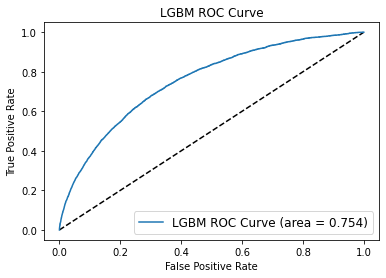

In [ ]:
#ROC_AUC Curve/Score
y_pred_prob = classifier_LGBM.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LGBM ROC Curve (area = {})'.format(round(roc_auc_score(y_test, y_pred_prob),3)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGBM ROC Curve')
plt.legend(fontsize=12)
plt.show()

In [ ]:
feature_importance_LGBM = classifier_LGBM.feature_importance()
features= df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1).columns
feature_importances_LGBM=pd.DataFrame(list(zip(features,feature_importance_LGBM/max(feature_importance_LGBM)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LGBM.head(10)

,features,importance
1,AMT_CREDIT,100.000000
2,AMT_ANNUITY,63.333333
291,installments_payments_AMT_PAYMENT_min,61.666667
39,DAYS_LAST_PHONE_CHANGE,60.555556
307,POS_CASH_CNT_INSTALMENT_FUTURE_mean,50.555556
4,DAYS_BIRTH,50.000000
7,DAYS_ID_PUBLISH,48.333333
5,DAYS_EMPLOYED,47.222222
106,bureau_AMT_CREDIT_SUM_DEBT_mean,39.444444
65,bureau_DAYS_CREDIT_min,38.333333


#### Most influential Features

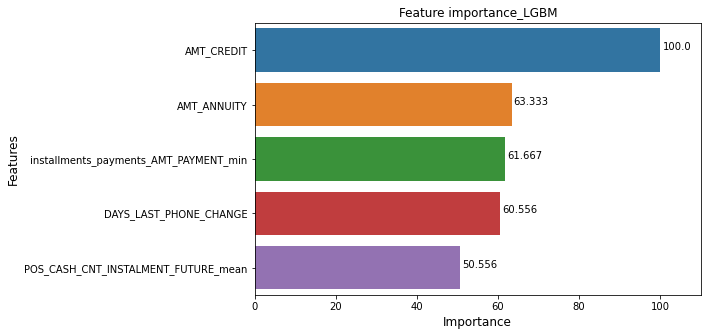

In [ ]:
plt.figure(figsize=(8,5))
ax=sns.barplot(y="features", x="importance", data=feature_importances_LGBM.head(5), orient='h')
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_xlim([0,110])
for p in ax.patches:
        x = p.get_x() + p.get_width() + 0.5
        y = p.get_y() + p.get_height()/2
        ax.annotate(round(p.get_width(),3), (x, y))

_=ax.set_title('Feature importance_LGBM', fontsize=12)

#### Classification report and confusion Matrix

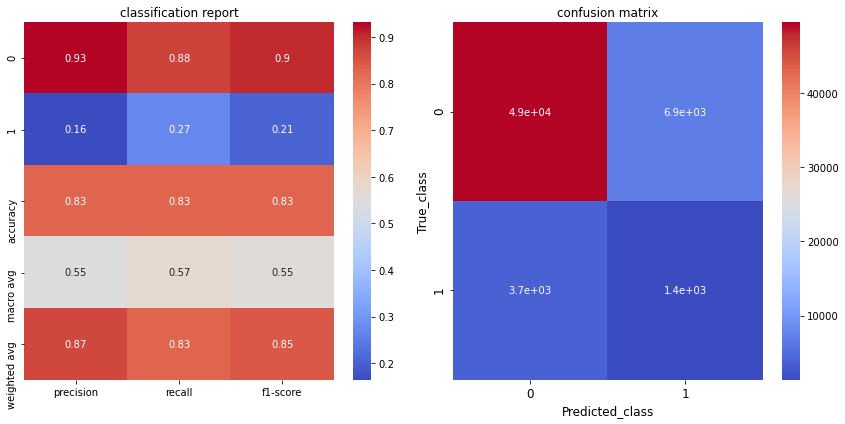

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()

f,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
sns.heatmap(report.drop('support',axis=1), annot=True, cmap="coolwarm", ax=ax1)
ax1.set_title('classification report')

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="coolwarm", ax=ax2)
ax2.tick_params(labelsize=12)
ax2.set_xlabel('Predicted_class', size=12)
ax2.set_ylabel('True_class', size=12)
ax2.set_title('confusion matrix')


plt.tight_layout()

plt.savefig('evaluation')


# 9) Final analysis

##### With Ext Sources

In [ ]:
df1 = pd.read_csv('Final_data/final_application_train_corr_0.98.csv')
df = pd.read_csv('Final_data/final_df_corr_0.98.csv')

In [ ]:
#Baseline
# Variable separation: Features and Target
X=df1.drop(['TARGET','SK_ID_CURR'], axis=1).values
y=df1['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_test1=X_test.copy()


# Train the Logistic Regression model on the Training set
classifier_Baseline_LR = LogisticRegression(random_state = 0)
classifier_Baseline_LR.fit(X_train, y_train)


#Better model
# Variable separation: Features and Target
X=df.drop(['TARGET','SK_ID_CURR'], axis=1).values
y=df['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


# Train the Logistic Regression model on the Training set
classifier_LR = LogisticRegression(random_state = 0, class_weight={0:1,1:10})
classifier_LR.fit(X_train, y_train)

classifier_L1_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')
classifier_L1_LR.fit(X_train, y_train)

classifier_DT = DecisionTreeClassifier(class_weight={0:1,1:10},random_state = 0)
classifier_DT.fit(X_train, y_train)

classifier_RF=RandomForestClassifier(random_state=0, class_weight={0:1,1:10})
classifier_RF.fit(X_train,y_train)

classifier_AB = AdaBoostClassifier(random_state = 0)
classifier_AB.fit(X_train, y_train)

classifier_xgb = XGBClassifier(random_stat=0, scale_pos_weight=10)
classifier_xgb.fit(X_train, y_train)

classifier_LGBM=lgb.LGBMClassifier(random_state=0, n_estimators=100, scale_pos_weight= 10)
classifier_LGBM.fit(X_train,y_train)


[02:14:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { random_stat } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [ ]:
#LGBM ROC_AUC
y_pred_prob8=classifier_LGBM.predict(X_test)
fpr8 , tpr8, thresholds8 = roc_curve(y_test, y_pred_prob8)
roc_auc_score(y_test, y_pred_prob8)

0.7523521709370687

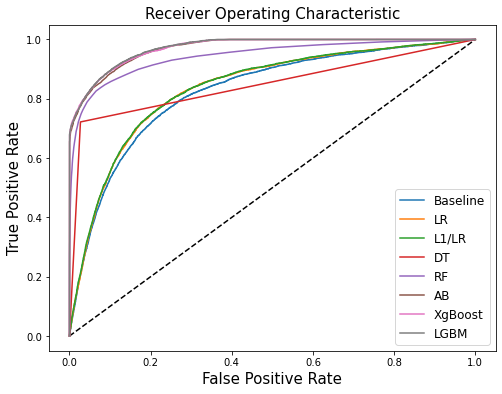

In [ ]:
#ROC Curve
from sklearn.metrics import roc_curve
plt.figure(figsize=(8,6))

y_pred_prob1 = classifier_Baseline_LR.predict_proba(X_test1)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test1, y_pred_prob1)

y_pred_prob2 = classifier_LR.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)


y_pred_prob3 = classifier_L1_LR.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)

y_pred_prob4 = classifier_DT.predict_proba(X_test)[:,1]
fpr4 , tpr4, thresholds4 = roc_curve(y_test, y_pred_prob4)

y_pred_prob5 = classifier_RF.predict_proba(X_test)[:,1]
fpr5 , tpr5, thresholds5 = roc_curve(y_test, y_pred_prob5)


y_pred_prob6 = classifier_AB.predict_proba(X_test)[:,1]
fpr6 , tpr6, thresholds6 = roc_curve(y_test, y_pred_prob6)

y_pred_prob7 = classifier_xgb.predict_proba(X_test)[:,1]
fpr7 , tpr7, thresholds7 = roc_curve(y_test, y_pred_prob7)

y_pred_prob8=classifier_LGBM.predict(X_test)
fpr8 , tpr8, thresholds8 = roc_curve(y_test, y_pred_prob8)




plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Baseline")
plt.plot(fpr2, tpr2, label= "LR")
plt.plot(fpr3, tpr3, label= "L1/LR")
plt.plot(fpr4, tpr4, label= "DT")
plt.plot(fpr5, tpr5, label= "RF")
plt.plot(fpr6, tpr6, label= "AB")
plt.plot(fpr7, tpr7, label= "XgBoost")
plt.plot(fpr8, tpr8, label= "LGBM")


plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('Receiver Operating Characteristic', fontsize=15)
plt.show()

In [ ]:
Models=['Baseline','LR','L1/LR', 'DT', 'RF', 'AdaBoost','XgBoost', 'LGBM']
df_score=pd.DataFrame(Models, columns=['Models'])
score=[roc_auc_score(y_test1, y_pred_prob1),roc_auc_score(y_test, y_pred_prob2),roc_auc_score(y_test, y_pred_prob3),roc_auc_score(y_test, y_pred_prob4),roc_auc_score(y_test, y_pred_prob5),roc_auc_score(y_test, y_pred_prob6),roc_auc_score(y_test, y_pred_prob7),roc_auc_score(y_test, y_pred_prob8)]
df_score['score']=score
df_score['score']=df_score['score'].apply(lambda x:np.round(x,3))
df_score

,Models,score
0,Baseline,0.825
1,LR,0.836
2,L1/LR,0.837
3,DT,0.847
4,RF,0.944
5,AdaBoost,0.971
6,XgBoost,0.972
7,LGBM,0.972


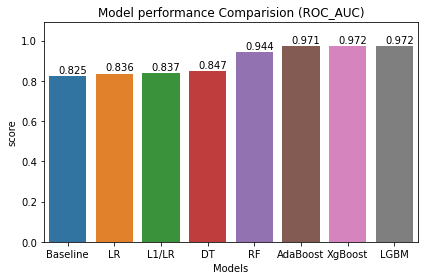

In [ ]:
plt.figure(figsize=(6,4))
ax=sns.barplot(x='Models',y='score',data=df_score)
plt.ylim([0,1.09])
plt.title('Model performance Comparision (ROC_AUC)')

for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+0.015))
plt.tight_layout()


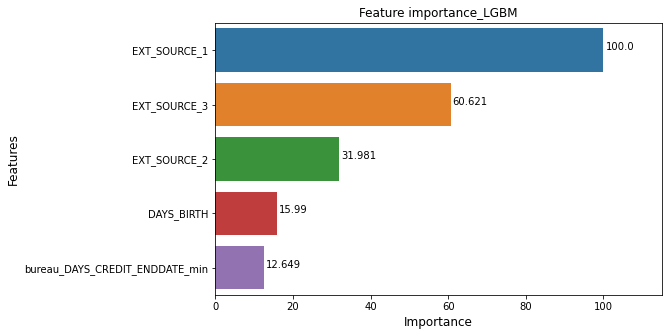

In [ ]:
feature_importance_LGBM = classifier_LGBM.feature_importance()
features= df.drop(['TARGET','SK_ID_CURR'], axis=1).columns
feature_importances_LGBM=pd.DataFrame(list(zip(features,feature_importance_LGBM/max(feature_importance_LGBM)*100)), columns=['features','importance']).sort_values('importance', ascending=False)

feature_importances_LGBM.head(10)

plt.figure(figsize=(8,5))
ax=sns.barplot(y="features", x="importance", data=feature_importances_LGBM.head(5), orient='h')
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_xlim([0,115])
for p in ax.patches:
        x = p.get_x() + p.get_width() + 0.5
        y = p.get_y() + p.get_height()/2
        ax.annotate(round(p.get_width(),3), (x, y))

_=ax.set_title('Feature importance_LGBM', fontsize=12)


##### Excluding Ext sources

In [ ]:
#Baseline
# Variable separation: Features and Target
X=df1.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).values
y=df1['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_test1=X_test.copy()
y_test1=y_test.copy()


# Train the Logistic Regression model on the Training set
classifier_Baseline_LR = LogisticRegression(random_state = 0)
classifier_Baseline_LR.fit(X_train, y_train)


#Better model
# Variable separation: Features and Target
X=df.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).values
y=df['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


# Train the Logistic Regression model on the Training set
classifier_LR = LogisticRegression(random_state = 0, class_weight={0:1,1:10})
classifier_LR.fit(X_train, y_train)

classifier_L1_LR = LogisticRegression(solver='liblinear', random_state = 0, class_weight={0:1,1:10}, penalty='l1')
classifier_L1_LR.fit(X_train, y_train)

classifier_DT = DecisionTreeClassifier(class_weight={0:1,1:10},random_state = 0)
classifier_DT.fit(X_train, y_train)

classifier_RF=RandomForestClassifier(random_state=0, class_weight={0:1,1:10})
classifier_RF.fit(X_train,y_train)

classifier_AB = AdaBoostClassifier(random_state = 0)
classifier_AB.fit(X_train, y_train)

classifier_xgb = XGBClassifier(random_stat=0, scale_pos_weight=10)
classifier_xgb.fit(X_train, y_train)

classifier_LGBM=lgb.LGBMClassifier(random_state=0, n_estimators=100, scale_pos_weight= 10)
classifier_LGBM.fit(X_train,y_train)

[19:18:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { random_stat } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




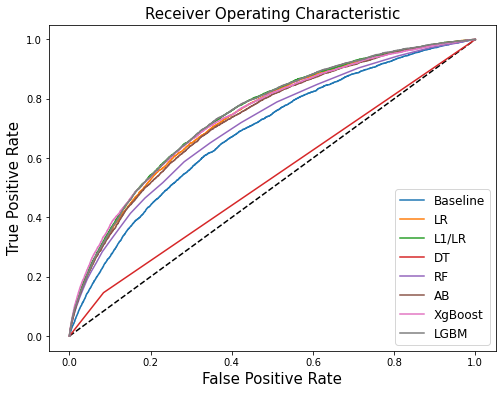

In [ ]:
#ROC Curve
from sklearn.metrics import roc_curve
plt.figure(figsize=(8,6))

y_pred_prob1 = classifier_Baseline_LR.predict_proba(X_test1)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test1, y_pred_prob1)

y_pred_prob2 = classifier_LR.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)


y_pred_prob3 = classifier_L1_LR.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)

y_pred_prob4 = classifier_DT.predict_proba(X_test)[:,1]
fpr4 , tpr4, thresholds4 = roc_curve(y_test, y_pred_prob4)

y_pred_prob5 = classifier_RF.predict_proba(X_test)[:,1]
fpr5 , tpr5, thresholds5 = roc_curve(y_test, y_pred_prob5)


y_pred_prob6 = classifier_AB.predict_proba(X_test)[:,1]
fpr6 , tpr6, thresholds6 = roc_curve(y_test, y_pred_prob6)

y_pred_prob7 = classifier_xgb.predict_proba(X_test)[:,1]
fpr7 , tpr7, thresholds7 = roc_curve(y_test, y_pred_prob7)

y_pred_prob8=classifier_LGBM.predict(X_test)
fpr8 , tpr8, thresholds8 = roc_curve(y_test, y_pred_prob8)




plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Baseline")
plt.plot(fpr2, tpr2, label= "LR")
plt.plot(fpr3, tpr3, label= "L1/LR")
plt.plot(fpr4, tpr4, label= "DT")
plt.plot(fpr5, tpr5, label= "RF")
plt.plot(fpr6, tpr6, label= "AB")
plt.plot(fpr7, tpr7, label= "XgBoost")
plt.plot(fpr8, tpr8, label= "LGBM")


plt.legend(fontsize=12)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('Receiver Operating Characteristic', fontsize=15)
plt.show()

In [ ]:
Models=['Baseline','LR','L1/LR', 'DT', 'RF', 'AdaBoost','XgBoost', 'LGBM']
df_score=pd.DataFrame(Models, columns=['Models'])
score=[roc_auc_score(y_test1, y_pred_prob1),roc_auc_score(y_test, y_pred_prob2),roc_auc_score(y_test, y_pred_prob3),roc_auc_score(y_test, y_pred_prob4),roc_auc_score(y_test, y_pred_prob5),roc_auc_score(y_test, y_pred_prob6),roc_auc_score(y_test, y_pred_prob7),roc_auc_score(y_test, y_pred_prob8)]
df_score['score']=score
df_score['score']=df_score['score'].apply(lambda x:np.round(x,3))
df_score

,Models,score
0,Baseline,0.685
1,LR,0.739
2,L1/LR,0.746
3,DT,0.531
4,RF,0.709
5,AdaBoost,0.733
6,XgBoost,0.742
7,LGBM,0.746


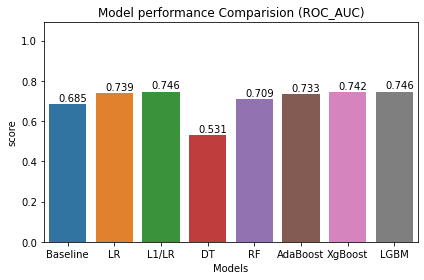

In [ ]:
plt.figure(figsize=(6,4))
ax=sns.barplot(x='Models',y='score',data=df_score)
plt.ylim([0,1.09])
plt.title('Model performance Comparision (ROC_AUC)')

for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+0.015))
plt.tight_layout()


#### Business Perspective

In [ ]:
X=df.drop(['TARGET','SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)
y=df['TARGET']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


import lightgbm as lgb

#train the model 
classifier_LGBM=lgb.LGBMClassifier(n_estimators=194, learning_rate=0.05,
 boosting_type='gbdt',
 objective='binary',
 metric='binary_logloss',
 max_depth= 75,
 subsample_freq= 10,
 subsample= 0.9,
 scale_pos_weight= 8,
 reg_lambda= 15,
 reg_alpha= 10,
 num_leaves= 25,
 min_split_gain= 0.3,
 colsample_bytree= 0.5)

classifier_LGBM.fit(X_train,y_train)

#prediction
y_pred=classifier_LGBM.predict(X_test)
y_pred_train=classifier_LGBM.predict(X_train)

y_pred_prob=classifier_LGBM.predict_proba(X_test)[:,1]
y_pred_prob_train=classifier_LGBM.predict_proba(X_train)[:,1]


from sklearn.metrics import classification_report,confusion_matrix
print('Test Data Metrics:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


print('\n')
print('Train Data Metrics:')
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

from sklearn.metrics import roc_auc_score
print("roc_auc (training): {0:.3f}".format(roc_auc_score(y_train, y_pred_prob_train)))
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, y_pred_prob)))


Test Data Metrics:
[[46449  9972]
 [ 2435  2588]]
              precision    recall  f1-score   support

           0       0.95      0.82      0.88     56421
           1       0.21      0.52      0.29      5023

    accuracy                           0.80     61444
   macro avg       0.58      0.67      0.59     61444
weighted avg       0.89      0.80      0.83     61444



Train Data Metrics:
[[186951  39041]
 [  8502  11278]]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89    225992
           1       0.22      0.57      0.32     19780

    accuracy                           0.81    245772
   macro avg       0.59      0.70      0.60    245772
weighted avg       0.90      0.81      0.84    245772

roc_auc (training): 0.789
roc_auc (test): 0.754


In [ ]:
#Train
df_prob_train=pd.DataFrame(y_train.values,columns=['Actual'])
df_prob_train['Predscore']=y_pred_prob_train
df_prob_train['pred']=y_pred_train
df_prob_train

,Actual,Predscore,pred
0,1,0.471561,0
1,1,0.569626,1
2,0,0.409989,0
3,0,0.354189,0
4,0,0.327828,0
...,...,...,...
245767,0,0.439739,0
245768,1,0.612372,1
245769,0,0.191792,0
245770,0,0.349708,0


In [ ]:
#Test
df_prob_test=pd.DataFrame(y_test.values,columns=['Actual'])
df_prob_test['Predscore']=y_pred_prob
df_prob_test['pred']=y_pred
df_prob_test

,Actual,Predscore,pred
0,0,0.249260,0
1,0,0.167015,0
2,0,0.269289,0
3,0,0.415531,0
4,0,0.105893,0
...,...,...,...
61439,0,0.435716,0
61440,0,0.534063,1
61441,0,0.509089,1
61442,0,0.103350,0


In [ ]:
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

0    225992
1     19780
Name: TARGET, dtype: int64
0    56421
1     5023
Name: TARGET, dtype: int64


**All the applicants were divided into 10 tiers by qcut in training data, so that wach tier contains approx. equal no. of good applicants.**

In [ ]:
#Train
finalResults = pd.DataFrame({
    'Actual' : y_train,
    'PredScore' : y_pred_prob_train#[:,1]
})

finalResults['QuantTier'], Dev_bins = pd.qcut(finalResults['PredScore'], 10, retbins=True, labels=range(1,11))
finalResults.reset_index(inplace=True)

badRateMatrix_train = pd.pivot_table(finalResults, index=['QuantTier'], columns=['Actual'], values = ['index'], aggfunc='count')
print(badRateMatrix_train)

           index      
Actual         0     1
QuantTier             
1          24404   174
2          24228   349
3          24088   489
4          23826   751
5          23611   966
6          23194  1383
7          22652  1925
8          21952  2625
9          20798  3779
10         17239  7339


In [ ]:
#Test
finalResults = pd.DataFrame({
    'Actual' : y_test,
    'PredScore' : y_pred_prob
})

finalResults['QuantTier'] = pd.cut(finalResults['PredScore'], bins=Dev_bins, labels=range(1,11))
finalResults.reset_index(inplace=True)

badRateMatrix_test= pd.pivot_table(finalResults, index=['QuantTier'], columns=['Actual'], values = ['index'], aggfunc='count')
print(badRateMatrix_test)

          index      
Actual        0     1
QuantTier            
1          6019    84
2          5934   110
3          6009   173
4          5901   235
5          5940   307
6          5756   388
7          5613   505
8          5570   667
9          5245   938
10         4431  1616


In [ ]:
good=badRateMatrix_test['index'][0].values
bad=badRateMatrix_test['index'][1].values
tier=badRateMatrix_test.index
badRate=pd.DataFrame(list(zip(tier,good,bad)), columns=(['tier','good','bad']))
badRate['% good']=badRate['good']/sum(badRate['good'].values)*100
badRate['% bad']=badRate['bad']/sum(badRate['bad'].values)*100
badRate

,tier,good,bad,% good,% bad
0,1,6019,84,10.668581,1.672307
1,2,5934,110,10.517920,2.189926
2,3,6009,173,10.650856,3.444157
3,4,5901,235,10.459428,4.678479
4,5,5940,307,10.528555,6.111885
5,6,5756,388,10.202418,7.724467
6,7,5613,505,9.948952,10.053753
7,8,5570,667,9.872736,13.278917
8,9,5245,938,9.296678,18.674099
9,10,4431,1616,7.853876,32.172009


In [ ]:
df=badRate[['tier','% good','% bad']]
df

,tier,% good,% bad
0,1,10.668581,1.672307
1,2,10.517920,2.189926
2,3,10.650856,3.444157
3,4,10.459428,4.678479
4,5,10.528555,6.111885
5,6,10.202418,7.724467
6,7,9.948952,10.053753
7,8,9.872736,13.278917
8,9,9.296678,18.674099
9,10,7.853876,32.172009


In [ ]:
df = pd.melt(df, id_vars="tier", var_name="good/bad", value_name="% count")
df

,tier,good/bad,% count
0,1,% good,10.668581
1,2,% good,10.517920
2,3,% good,10.650856
3,4,% good,10.459428
4,5,% good,10.528555
5,6,% good,10.202418
6,7,% good,9.948952
7,8,% good,9.872736
8,9,% good,9.296678
9,10,% good,7.853876


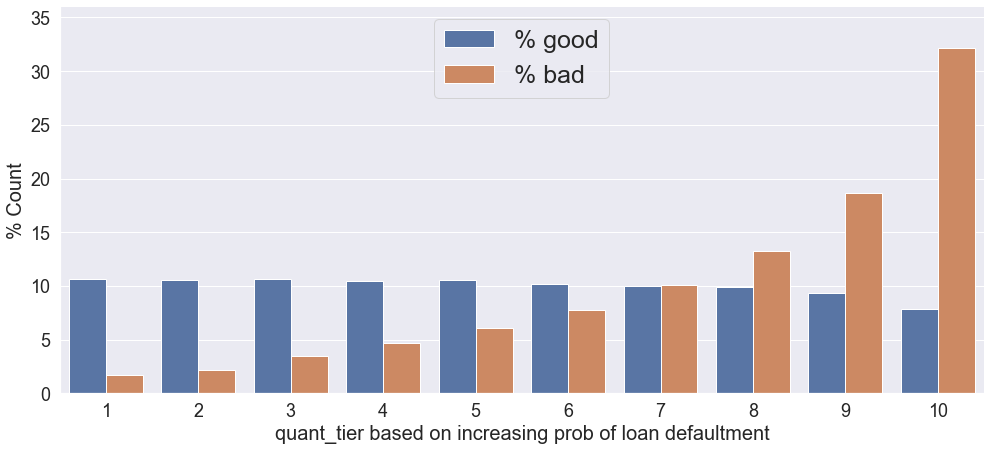

In [ ]:
sns.set_theme()
sns.catplot(x='tier', y='% count', hue='good/bad', data=df, kind='bar', height=6, aspect=2.25, legend=None)

plt.legend(loc=9, prop={'size': 25})
plt.xlabel('quant_tier based on increasing prob of loan defaultment',fontsize=20)
plt.ylabel('% Count',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0,36])

plt.show()


# 10) ANN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [ ]:
df = pd.read_csv('Final_data/final_df_corr_0.98.csv')


# Variable separation: Features and Target
X=df.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).values
y=df['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


In [ ]:
X_train.shape

(245772, 523)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

from tensorflow.keras.layers import Dropout

In [ ]:
model = Sequential()
model.add(Dense(units=523,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=261,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=130,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=65, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Train on 245772 samples, validate on 61444 samples
Epoch 1/600
245772/245772 [==============================] - 74s 303us/sample - loss: 0.2900 - val_loss: 0.2768
Epoch 2/600
245772/245772 [==============================] - 50s 204us/sample - loss: 0.2729 - val_loss: 0.2770
Epoch 3/600
245772/245772 [==============================] - 53s 215us/sample - loss: 0.2729 - val_loss: 0.2750
Epoch 4/600
245772/245772 [==============================] - 49s 200us/sample - loss: 0.2726 - val_loss: 0.2735
Epoch 5/600
245772/245772 [==============================] - 48s 197us/sample - loss: 0.2727 - val_loss: 0.2778
Epoch 6/600
245772/245772 [==============================] - 49s 200us/sample - loss: 0.2728 - val_loss: 0.2785
Epoch 7/600
245772/245772 [==============================] - 49s 201us/sample - loss: 0.2724 - val_loss: 0.2753
Epoch 8/600
245772/245772 [==============================] - 55s 222us/sample - loss: 0.2733 - val_loss: 0.2743
Epoch 9/600
245772/245772 [==========================

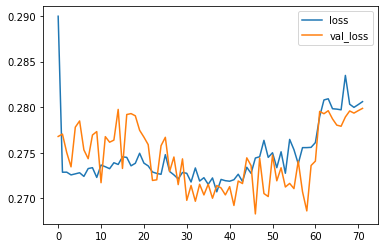

In [ ]:


from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

from tensorflow.keras.layers import Dropout



model = Sequential()
model.add(Dense(units=523,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=261,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=130,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=65, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')


model.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )



model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [ ]:
predictions = model.predict_classes(X_test)

In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56501
           1       0.00      0.00      0.00      4943

    accuracy                           0.92     61444
   macro avg       0.46      0.50      0.48     61444
weighted avg       0.85      0.92      0.88     61444



In [ ]:
print(confusion_matrix(y_test,predictions))

[[56501     0]
 [ 4943     0]]


In [ ]:
# Variable separation: Features and Target
X=df.drop(['TARGET','SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'], axis=1).values
y=df['TARGET'].values

# Train-Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Data Scaling using MinMax Scalar
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


In [ ]:
model1 = Sequential()
model1.add(Dense(units=523,activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(units=261,activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(units=130,activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(units=65, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(units=32, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(units=16, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(units=1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam')

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

from tensorflow.keras.layers import Dropout


model1.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Train on 245772 samples, validate on 61444 samples
Epoch 1/600
245772/245772 [==============================] - 83s 337us/sample - loss: 0.2898 - val_loss: 0.2658
Epoch 2/600
245772/245772 [==============================] - 49s 198us/sample - loss: 0.2728 - val_loss: 0.2700
Epoch 3/600
245772/245772 [==============================] - 49s 199us/sample - loss: 0.2707 - val_loss: 0.2669
Epoch 4/600
245772/245772 [==============================] - 49s 201us/sample - loss: 0.2694 - val_loss: 0.2654
Epoch 5/600
245772/245772 [==============================] - 50s 204us/sample - loss: 0.2693 - val_loss: 0.2634
Epoch 6/600
245772/245772 [==============================] - 50s 202us/sample - loss: 0.2697 - val_loss: 0.2699
Epoch 7/600
245772/245772 [==============================] - 51s 206us/sample - loss: 0.2700 - val_loss: 0.2676
Epoch 8/600
245772/245772 [==============================] - 50s 204us/sample - loss: 0.2696 - val_loss: 0.2637
Epoch 9/600
245772/245772 [==========================

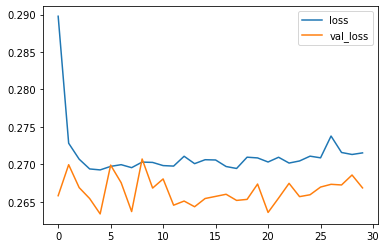

In [ ]:
model_loss_1 = pd.DataFrame(model1.history.history)
model_loss_1.plot()

In [ ]:
predictions_1 = model1.predict_classes(X_test)
print(classification_report(y_test,predictions_1))
print(confusion_matrix(y_test,predictions_1))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56501
           1       0.00      0.00      0.00      4943

    accuracy                           0.92     61444
   macro avg       0.46      0.50      0.48     61444
weighted avg       0.85      0.92      0.88     61444

[[56501     0]
 [ 4943     0]]


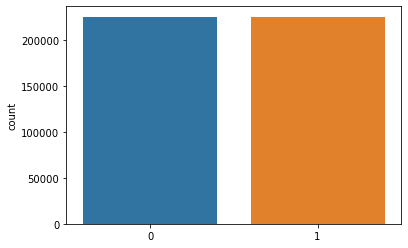

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
sm = SMOTE(random_state = 101)

X_train_new, y_train_new = sm.fit_sample(X_train, y_train.ravel())

sns.countplot(pd.Series(y_train_new))

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

X_train_new=scaler.fit_transform(X_train_new)
X_test_new=scaler.transform(X_test)
y_train_new=y_train_new

In [ ]:
model2 = Sequential()
model2.add(Dense(units=523,activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(units=261,activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(units=130,activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(units=65, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(units=32, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(units=16, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(units=1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam')


from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

from tensorflow.keras.layers import Dropout

model2.fit(x=X_train_new, 
          y=y_train_new, 
          epochs=600,
          validation_data=(X_test_new, y_test), verbose=1,
          callbacks=[early_stop]
          )

Train on 451824 samples, validate on 61444 samples
Epoch 1/600
451824/451824 [==============================] - 100s 221us/sample - loss: 0.5653 - val_loss: 0.6170
Epoch 2/600
451824/451824 [==============================] - 81s 179us/sample - loss: 0.4779 - val_loss: 0.5456
Epoch 3/600
451824/451824 [==============================] - 90s 198us/sample - loss: 0.4403 - val_loss: 0.5804
Epoch 4/600
451824/451824 [==============================] - 92s 205us/sample - loss: 0.4176 - val_loss: 0.6884
Epoch 5/600
451824/451824 [==============================] - 89s 198us/sample - loss: 0.4050 - val_loss: 0.5273
Epoch 6/600
451824/451824 [==============================] - 89s 198us/sample - loss: 0.3950 - val_loss: 0.6421
Epoch 7/600
451824/451824 [==============================] - 90s 200us/sample - loss: 0.3874 - val_loss: 0.7265
Epoch 8/600
451824/451824 [==============================] - 92s 205us/sample - loss: 0.3810 - val_loss: 0.6069
Epoch 9/600
451824/451824 [=========================

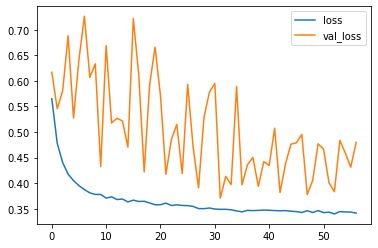

In [ ]:
model_loss_2 = pd.DataFrame(model2.history.history)
model_loss_2.plot()

In [ ]:
predictions_2= model2.predict_classes(X_test_new)
print(classification_report(y_test,predictions_2))
print(confusion_matrix(y_test,predictions_2))

              precision    recall  f1-score   support

           0       0.94      0.87      0.91     56501
           1       0.19      0.34      0.24      4943

    accuracy                           0.83     61444
   macro avg       0.56      0.61      0.57     61444
weighted avg       0.88      0.83      0.85     61444

[[49430  7071]
 [ 3284  1659]]


In [ ]:
predictions_3= model2.predict_proba(X_test_new)

predictions_3

array([[0.44029525],
       [0.17716835],
       [0.47030172],
       ...,
       [0.2591871 ],
       [0.4855347 ],
       [0.37441185]], dtype=float32)

In [ ]:
from sklearn.metrics import roc_auc_score
print("roc_auc (test): {0:.3f}".format(roc_auc_score(y_test, predictions_3)))

roc_auc (test): 0.674
